## Objectives

Introduce leak at node 6, node 2. The pressure measurement of these nodes will be used as a desired output for each of the optimization. Hence, the input function will be the considered emitter coefficient value of 0.5 and optimize for 100 generations. 

## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
import warnings
import shutil
warnings.filterwarnings('ignore')

In [4]:
# wipe all solutions in the directory

try:
    shutil.rmtree('../leak_size_results/add_leak_node6/temp-new/')
    shutil.rmtree('../leak_size_results/add_leak_node6/plots-new/')
    print('Folders Deleted')
except FileNotFoundError as e:
    print(e)

# recreate deleted folders
os.makedirs('../leak_size_results/add_leak_node6/temp-new')
os.makedirs('../leak_size_results/add_leak_node6/plots-new')


# Uncomment and run the above code if you want to re-optimze this project otherwise, go ahead.
# Recommendation: Uncomment and run the code if you want re-optimize.

Folders Deleted


## Read Inp File

In [5]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 2 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 30 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    last_fitness = 0
    mutation_percent_genes = 100
    
    
    inp_file_path = r"../data/Real_Synthetic_Net.inp" 
    function_inputs = None
    desired_output = None

In [6]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        
        # Check if node is in network 
        wn = wntr.network.WaterNetworkModel(self.inp_file_path)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        
        self.node = node
        
        #Setup all neccessary folders we need to work with, i.e. create them if they don't exist
        if not os.path.exists('../leak_size_results/add_leak_node6/temp-new/solutions_for_'+self.node):
            os.mkdir('../leak_size_results/add_leak_node6/temp-new/solutions_for_'+self.node)
            
        if not os.path.exists('../leak_size_results/add_leak_node6/plots-new/plots_for_'+self.node):
            os.mkdir('../leak_size_results/add_leak_node6/plots-new/plots_for_'+self.node)
        
        if not os.path.exists('../leak_size_results/add_leak_node6/merged_results-new/'):
            os.mkdir('../leak_size_results/add_leak_node6/merged_results-new/')
            
        self.temp_dir = '../leak_size_results/add_leak_node6/temp-new/solutions_for_'+self.node
        self.plots_dir = '../leak_size_results/add_leak_node6/plots-new/plots_for_'+self.node
        self.merged_results = '../leak_size_results/add_leak_node6/merged_results-new/results_for_'
        
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,self.node]
        
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        wn: wntr network object
        emitter_value: the emitter coefficient value
        """
        
        if emitter_value > 1:
            emitter_value %=1
            
        # Change emitter coefficient
        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list,  name:str, path=None):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not path: path=self.merged_results
            
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
            
    def run(self, leak_area=0.00015, start_time=0, end_time=1, discharge_coeff=.5, function_inputs=.5, plot_graph=True):
        """
        Adds a leak to node passed to WaterLeakModel() object and simulates
        
        parameters
        ----------
        leak_area: area of the leak
        start_time: time in seconds to start the leak
        end_time: time in seconds to end the leak
        discharge_coeff: Leak discharge coefficient; Takes on values between 0 and 1.
        function_inputs = inputs for optimization, can be array of numbers
        plot_graph: If plot_graph is set to true, a graph of the network is plotted after simulation
        """
            
        # Add leak and simulate
        wn = wntr.network.WaterNetworkModel(self.inp_file_path)
        node = wn.get_node(self.node)
        node.add_leak(wn, area=0.00015, start_time=start_time, end_time=end_time, discharge_coeff=discharge_coeff)
        results = self.simulate(wn, plot_graph=plot_graph)

        self.function_inputs = function_inputs
        self.desired_output = node.head-node.elevation
        return results


## Experiment 1
Add Leak to Node 6 and Optimize

In [7]:
# Instantiate the pygad optimization class
water_model = WaterLeakModel(node='N6')
wn = wntr.network.WaterNetworkModel(water_model.inp_file_path)

pressure_at_0hr = water_model.simulate(wn, plot_graph=False)
pressure_at_0hr.node['pressure']

,N1,N5,N10,N7,N2,N6,N3,N8,N13,N9,N14,N4,N11,N12,N15,N16,Reservior
0,9.370611,24.023646,28.970101,27.256189,24.870362,26.61794,27.085028,25.159246,30.595309,24.372273,25.061021,29.000316,27.842038,24.588272,28.966055,27.253194,0.0


In [34]:
# export pressure_at_0hr to excel
pressure_at_0hr.node['pressure'].T.to_csv('../leak_size_results/add_leak_node6/pressure_at_0hr.csv')
pressure_at_0hr.node['demand'].T.to_csv('../leak_size_results/add_leak_node6/demand_at_0hr.csv')
# export flow rate
pressure_at_0hr.link['flowrate'].T.to_csv('../leak_size_results/add_leak_node6/flowrate_at_0hr.csv')

In [35]:
pressure_at_0hr.node['demand'].T

,0
N1,0.00100
N5,0.01300
N10,0.00120
N7,0.00121
N2,0.01260
N6,0.01010
N3,0.00110
N8,0.02300
N13,0.00170
N9,0.00390


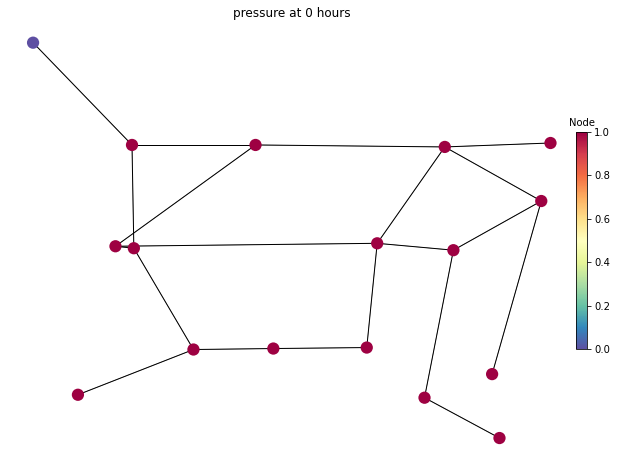

In [8]:
results = water_model.run()

In [9]:
results.node['pressure']

,N1,N5,N10,N7,N2,N6,N3,N8,N13,N9,N14,N4,N11,N12,N15,N16,Reservior
0,9.344181,23.981771,28.928226,27.184643,24.823445,26.540357,27.033414,25.093107,30.52917,24.308689,24.997437,28.948702,27.800164,24.522134,28.924181,27.181648,0.0


After leak was added to our selected node `6` our pressure dropped from 26.61 to 26.54

In [10]:
water_model.desired_output

26.540357400761586

In [11]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(water_model.inp_file_path)
    
#     output = numpy.sum(solution*function_inputs)
    results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0]*water_model.function_inputs)) #change emitter coefficient
    
    pressure = results.node['pressure']
    pressure_output = pressure.loc[:,water_model.node]
    
    demands=results.node['demand']
    demand_output = demands.loc[:,water_model.node]
    
    fitness = 1.0 / (np.abs(pressure_output - water_model.desired_output) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','PRESSURE_OUTPUT','OUTPUT_DEMAND','FITNESS'])
    
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]*water_model.function_inputs),'PRESSURE_OUTPUT':list(pressure_output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(demand_output) [0]*1000)},ignore_index=True)
    data.to_csv(f"{water_model.temp_dir}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 
    
    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0]*water_model.function_inputs,3)),'|===========|',list(round(pressure_output,3))[0],'|==================|',list(round(fitness, 3))[0],'|==========')
    print('================================='*2)

    return list(fitness)[0]

In [12]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{water_model.temp_dir}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [13]:
# Instantiate the pygad optimization class
ga_instance = pygad.GA(num_generations=water_model.num_generations,
                       num_parents_mating=water_model.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=water_model.sol_per_pop,
                       num_genes=water_model.num_genes,
                       init_range_low=water_model.init_range_low,
                       init_range_high=water_model.init_range_high,
                       parent_selection_type=water_model.parent_selection_type,
                       keep_parents=water_model.keep_parents,
                       crossover_type=water_model.crossover_type,
                       mutation_type=water_model.mutation_type,
                       mutation_percent_genes=water_model.mutation_percent_genes,
                       callback_generation=callback_generation)

In [14]:
ga_instance.run()

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==================| 17.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |==================| 37.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 26.593 |==================| 19.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 51.879 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 26.571 |==================| 33.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 26.561 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 26.583 |==================| 23.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.641 |===========| 26.518 |==================| 44.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |==================| 16.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 26.61 |==================| 14.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |===========| 26.516 |==================| 41.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 26.589 |==================| 20.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 26.532 |==================| 120.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.0 |===========| 26.618 |==================| 12.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 26.535 |==================| 201.34 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 26.548 |==================| 130.474 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.56 |===========| 26.531 |==================| 105.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |==================| 16.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 26.496 |==================| 22.718 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 26.525 |==================| 64.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |==================| 21.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.577 |==================| 26.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 26.583 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |==================| 36.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 26.504 |==================| 27.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 26.48 |==================| 16.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 26.532 |==================| 120.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.0 |===========| 26.618 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 26.492 |==================| 20.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 26.572 |==================| 31.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 26.572 |==================| 31.749 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 26.591 |==================| 19.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 26.48 |==================| 16.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.592 |===========| 26.526 |==================| 68.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 26.526 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 26.543 |==================| 332.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |==================| 73.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 26.579 |==================| 25.647 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 26.483 |==================| 17.529 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |==================| 25.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 168.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 26.478 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 26.588 |==================| 20.984 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.358 |===========| 26.563 |==================| 45.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 26.516 |==================| 41.614 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 26.492 |==================| 20.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 26.572 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.157 |===========| 26.594 |==================| 18.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |==================| 14.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.572 |==================| 31.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |==================| 13.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |==================| 123.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 26.587 |==================| 21.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 26.551 |==================| 90.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 26.515 |==================| 40.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 26.529 |==================| 91.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 26.521 |==================| 50.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |==================| 50.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.747 |===========| 26.501 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 26.611 |==================| 14.176 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 26.478 |==================| 15.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.546 |==================| 163.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.565 |==================| 41.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.157 |===========| 26.594 |==================| 18.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |==================| 14.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.572 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 26.612 |==================| 14.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 26.517 |==================| 42.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 26.577 |==================| 27.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.37 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 26.551 |==================| 90.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 26.515 |==================| 40.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 26.529 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.58 |===========| 26.528 |==================| 79.343 |==========
Generation = 4
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |==================| 20.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 26.473 |==================| 14.743 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |==================| 16.87 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.797 |===========| 26.493 |==================| 21.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 26.618 |==================| 12.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.493 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |==================| 18.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 26.468 |==================| 13.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.171 |===========| 26.592 |==================| 19.472 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 26.562 |==================| 46.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 39.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.758 |===========| 26.499 |==================| 24.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |==================| 176.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.938 |===========| 26.471 |==================| 14.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 26.474 |==================| 15.106 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1246.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.58 |===========| 26.528 |==================| 79.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.995 |===========| 26.462 |==================| 12.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 26.565 |==================| 40.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.574 |==================| 29.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 26.462 |==================| 12.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 26.495 |==================| 22.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 26.52 |==================| 50.156 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 26.491 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |==================| 15.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.934 |===========| 26.471 |==================| 14.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.571 |==================| 32.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 26.463 |==================| 12.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |==================| 40.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 26.56 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 26.615 |==================| 13.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 26.473 |==================| 14.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.995 |===========| 26.462 |==================| 12.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 26.565 |==================| 40.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.574 |==================| 29.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 26.462 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.125 |===========| 26.599 |==================| 17.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |==================| 18.046 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |==================| 15.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.934 |===========| 26.471 |==================| 14.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.571 |==================| 32.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 26.463 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 26.616 |==================| 13.18 |==========
Generation = 6
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.123 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.546 |==================| 163.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 26.518 |==================| 45.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.053 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.601 |==================| 16.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |==================| 65.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 26.546 |==================| 189.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |==================| 13.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.963 |===========| 26.467 |==================| 13.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==================| 57.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 26.548 |==================| 129.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 26.57 |==================| 33.317 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 26.605 |==================| 15.503 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 26.574 |==================| 29.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 26.569 |==================| 34.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 26.616 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |==================| 14.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 26.553 |==================| 80.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.941 |===========| 26.47 |==================| 14.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 26.563 |==================| 43.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 26.491 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 26.539 |==================| 686.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |==================| 28.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |==================| 16.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 26.476 |==================| 15.532 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |==================| 141.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 26.475 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 26.525 |==================| 65.176 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.56 |===========| 26.531 |==================| 105.819 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.694 |===========| 26.51 |==================| 32.645 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.343 |===========| 26.565 |==================| 40.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |==================| 14.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |==================| 78.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 26.462 |==================| 12.803 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 26.595 |==================| 18.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 26.539 |==================| 686.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |==================| 28.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.546 |==================| 165.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 26.563 |==================| 43.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 26.468 |==================| 13.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |==================| 48.718 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.154 |==========
Generation = 8
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |==================| 13.466 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 26.474 |==================| 15.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 26.548 |==================| 128.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |==================| 29.156 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.804 |===========| 26.492 |==================| 20.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 26.514 |==================| 37.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.574 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 26.61 |==================| 14.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 26.484 |==================| 17.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.797 |===========| 26.493 |==================| 21.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 26.52 |==================| 48.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.807 |===========| 26.492 |==================| 20.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.546 |==================| 165.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 26.563 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |===========| 26.516 |==================| 41.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 26.505 |==================| 27.926 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.572 |===========| 26.529 |==================| 88.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 26.552 |==================| 87.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 26.524 |==================| 59.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.758 |===========| 26.5 |==================| 24.485 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 26.6 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 26.537 |==================| 287.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 26.504 |==================| 27.297 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 26.509 |==================| 31.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 |==================| 30.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 26.516 |==================| 41.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 74.623 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 26.56 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.735 |===========| 26.503 |==================| 26.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 203.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.535 |===========| 26.535 |==================| 182.255 |==========
Change = 1827.670241127271
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 26.503 |==================| 26.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |===========| 26.516 |==================| 41.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 149.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 30.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 26.513 |==================| 36.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 26.537 |==================| 287.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 26.504 |==================| 27.297 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 26.509 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 26.603 |==================| 15.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 26.498 |==================| 23.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.532 |==================| 115.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 26.578 |==================| 26.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==================| 25.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 26.547 |==================| 159.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 26.537 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 82.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 47.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 26.514 |==================| 37.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 26.49 |==================| 19.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.834 |===========| 26.487 |==================| 18.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 26.577 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |==================| 301.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.563 |==================| 45.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 26.593 |==================| 18.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |==================| 13.511 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.125 |===========| 26.599 |==================| 17.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 26.603 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 26.547 |==================| 159.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 26.537 |==================| 279.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.936 |===========| 26.471 |==================| 14.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491 |==================| 20.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 26.575 |==================| 28.756 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 26.537 |==================| 332.567 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |==================| 436.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.993 |===========| 26.462 |==================| 12.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.151 |===========| 26.595 |==================| 18.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 26.581 |==================| 24.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 26.462 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==================| 41.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |==================| 14.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.572 |===========| 26.529 |==================| 88.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.535 |===========| 26.535 |==================| 182.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.284 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.554 |===========| 26.532 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |==================| 12.957 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==================| 13.421 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.718 |===========| 26.506 |==================| 29.062 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 26.513 |==================| 36.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 26.526 |==================| 70.832 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 26.537 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 26.55 |==================| 101.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 26.48 |==================| 16.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.776 |===========| 26.497 |==================| 22.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 26.541 |==================| 3260.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 26.477 |==================| 15.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.579 |==================| 25.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.564 |===========| 26.53 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 26.546 |==================| 191.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |==================| 25.471 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.123 |==========
Fitness = 3260.5937041079
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 26.496 |==================| 22.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 26.506 |==================| 28.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.996 |===========| 26.461 |==================| 12.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 26.559 |==================| 53.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 26.597 |==================| 17.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |==================| 26.367 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 26.597 |==================| 17.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 26.55 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.564 |===========| 26.53 |==================| 98.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 26.559 |==================| 54.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 26.499 |==================| 24.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 51.184 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 26.546 |==================| 191.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 26.531 |==================| 106.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 26.478 |==================| 16.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 26.588 |==================| 20.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==================| 18.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 26.596 |==================| 17.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 26.598 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.594 |===========| 26.526 |==================| 67.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 26.49 |==================| 19.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 26.518 |==================| 45.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |==================| 16.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |==================| 18.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 26.515 |==================| 39.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 26.537 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.841 |===========| 26.486 |==================| 18.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 26.58 |==================| 25.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.585 |===========| 26.527 |==================| 75.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 26.531 |==================| 106.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 26.478 |==================| 16.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 26.588 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 26.471 |==================| 14.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |==================| 65.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 26.524 |==================| 59.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 26.613 |==================| 13.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 26.528 |==================| 84.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 26.516 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 26.502 |==================| 26.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 26.548 |==================| 122.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 26.498 |==================| 23.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.0 |===========| 26.618 |==================| 12.896 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |==================| 13.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 26.489 |==================| 19.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 26.542 |==================| 656.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 147.778 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.5 |===========| 26.54 |==================| 18062.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.891 |===========| 26.478 |==================| 16.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 26.471 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.667 |===========| 26.514 |==================| 37.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |==================| 32.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.683 |===========| 26.511 |==================| 34.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 26.582 |==================| 23.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 26.502 |==================| 26.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 26.548 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 26.544 |==================| 275.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 26.571 |==================| 32.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 26.525 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 26.521 |==================| 51.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 26.584 |==================| 23.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |==================| 22.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 26.564 |==================| 42.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.471 |==================| 14.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.895 |===========| 26.478 |==================| 15.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 26.475 |==================| 15.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |==================| 14.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 17.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 26.473 |==================| 14.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.582 |==================| 23.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 26.554 |==================| 71.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 26.538 |==================| 438.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 26.515 |==================| 40.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 26.49 |==================| 20.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 26.495 |==================| 21.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 12.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |==================| 15.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |==================| 14.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 26.472 |==================| 14.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 26.608 |==================| 14.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |==================| 2312.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 26.498 |==================| 23.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 26.49 |==================| 19.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.683 |===========| 26.511 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 26.489 |==================| 19.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.776 |===========| 26.497 |==================| 22.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 26.512 |==================| 35.448 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.989 |===========| 26.462 |==================| 12.837 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 26.52 |==================| 49.623 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 26.475 |==================| 15.251 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 26.538 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |==================| 15.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |==================| 23.26 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.858 |===========| 26.483 |==================| 17.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.701 |===========| 26.509 |==================| 31.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 51.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 26.505 |==================| 28.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.068 |===========| 26.608 |==================| 14.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |==================| 2368.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.693 |==========
Generation = 17
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 26.602 |==================| 16.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 26.494 |==================| 21.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.575 |===========| 26.529 |==================| 84.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 26.505 |==================| 28.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 26.602 |==================| 16.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |==================| 21.808 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 26.513 |==================| 37.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.743 |===========| 26.502 |==================| 25.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.511 |===========| 26.539 |==================| 554.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |==================| 93.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |==================| 48.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 51.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 26.505 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 26.595 |==================| 18.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==================| 46.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 48.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.949 |===========| 26.469 |==================| 14.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 26.501 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.938 |===========| 26.471 |==================| 14.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 26.507 |==================| 30.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.747 |===========| 26.501 |==================| 25.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 26.576 |==================| 28.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |==================| 65.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |==================| 23.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.619 |===========| 26.522 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.932 |===========| 26.472 |==================| 14.575 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.833 |===========| 26.487 |==================| 18.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 26.595 |==================| 18.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==================| 46.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 48.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.949 |===========| 26.469

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.868 |===========| 26.482 |==================| 17.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |==================| 50.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.938 |===========| 26.471 |==================| 14.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 26.507 |==================| 30.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.747 |===========| 26.501 |==================| 25.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 26.576 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |==================| 67.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.724 |===========| 26.505 |==================| 28.173 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==================| 211.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 26.537 |==================| 345.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.969 |===========| 26.466 |==================| 13.387 |==========
Generation = 19
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 26.4

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.691 |===========| 26.51 |==================| 33.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1293.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 26.463 |==================| 12.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.545 |===========| 26.533 |==================| 139.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 26.504 |==================| 27.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.804 |===========| 26.492 |==================| 20.73 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |==================| 23.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.887 |===========| 26.479 |==================| 16.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 26.464 |==================| 13.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 26.603 |==================| 16.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |==================| 67.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.724 |===========| 26.505 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |==================| 16.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536 |==================| 215.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |==================| 64.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 26.488 |==================| 19.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 26.518 |==================| 45.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |==================| 34.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 26.537 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |==================| 23.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 26.591 |==================| 19.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 26.482 |==================| 17.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 26.544 |==================| 276.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |==================| 2028.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 26.516 |==================| 41.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 26.537 |==================| 288.744 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.634 |===========| 26.519 |==================| 47.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.532 |==================| 115.265 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 26.521 |==================| 50.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |==================| 16.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 26.537 |==================| 261.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 26.561 |==================| 49.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |==================| 150.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==================| 41.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |==================| 23.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 26.591 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.59 |==================| 20.346 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.533 |===========| 26.535 |==================| 191.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 26.59 |==================| 20.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 26.521 |==================| 51.039 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.151 |===========| 26.595 |==================| 18.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 26.56 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.978 |===========| 26.464 |==================| 13.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 26.487 |==================| 18.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 26.602 |==================| 16.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.73 |===========| 26.504 |==================| 27.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 26.567 |==================| 38.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.16 |===========| 26.593 |==================| 18.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 133.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |==================| 43.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |==================| 25.309 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |==================| 13.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 26.504 |==================| 27.196 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.59 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 26.56 |==================| 50.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 26.525 |==================| 67.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.631 |===========| 26.52 |==================| 48.517 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 26.508 |==================| 31.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 26.477 |==================| 15.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 26.529 |==================| 91.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.558 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 154.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 26.485 |==================| 17.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 26.551 |==================| 90.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |==================| 25.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.536 |===========| 26.535 |==================| 177.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.547 |==================| 162.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 26.466 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |==================| 21.124 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 26.597 |==================| 17.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 26.583 |==================| 23.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |==================| 12.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.589 |==================| 20.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.558 |==================| 58.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 128.542 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.875 |===========| 26.481 |==================| 16.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 26.557 |==================| 61.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 26.524 |==================| 59.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 154.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 26.485 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 26.545 |==================| 224.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 26.561 |==================| 49.312 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 26.474 |==================| 15.058 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |==================| 57.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 26.552 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 26.534 |==================| 160.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |==================| 129.711 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.585 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.302 |===========| 26.571 |==================| 32.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.804 |===========| 26.492 |==================| 20.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 41.058 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.742 |===========| 26.502 |==================| 26.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.544 |==================| 313.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.678 |===========| 26.512 |==================| 35.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 26.572 |==================| 31.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 356.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 26.545 |==================| 224.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 26.552 |==================| 82.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 30.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |==================| 15.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.176 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.949 |===========| 26.469 |==================| 13.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 26.534 |==================| 160.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 26.462 |==================| 12.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |==================| 28.618 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 26.509 |==================| 31.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 26.582 |==================| 24.161 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 26.535 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |==================| 14.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.916 |===========| 26.474 |==================| 15.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.165 |===========| 26.593 |==================| 19.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 26.485 |==================| 17.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 26.608 |==================| 14.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |==================| 14.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 26.548 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 26.574 |==================| 29.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.829 |===========| 26.488 |==================| 19.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==================| 14.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 26.549 |==================| 110.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.742 |===========| 26.502 |==================| 26.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 26.462 |==================| 12.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |==================| 29.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 26.469 |==================| 14.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 26.582 |==================| 24.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.69 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 29.977 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 26.486 |==================| 18.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 26.608 |==================| 14.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 26.474 |==================| 15.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.571 |===========| 26.529 |==================| 89.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |==================| 27.676 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 26.504 |==================| 27.593 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==================| 50.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 26.57 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 26.564 |==================| 42.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 26.488 |==================| 19.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 26.503 |==================| 26.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 26.577 |==================| 27.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.853 |===========| 26.484 |==================| 17.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |==================| 29.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 26.469 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |==================| 14.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |==================| 36.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 |==================| 15.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.749 |===========| 26.501 |==================| 25.355 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.633 |===========| 26.519 |==================| 47.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 26.608 |==================| 14.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 26.474 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |==================| 35.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 26.577 |==================| 27.544 |==========
Generation = 26
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 47.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 26.496 |==================| 22.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 26.468 |==================| 13.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.807 |===========| 26.492 |==================| 20.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.56 |===========| 26.531 |==================| 105.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |==================| 13.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.866 |===========| 26.482 |==================| 17.236 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |==================| 26.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 26.481 |==================| 16.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 26.598 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 26.501 |==================| 25.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 26.503 |==================| 27.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 26.589 |==================| 20.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |==================| 35.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 26.577 |==================| 27.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.557 |==================| 61.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 26.572 |==================| 31.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 26.567 |==================| 37.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==================| 25.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.557 |==================| 58.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 51.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 26.488 |==================| 19.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 26.477 |==================| 15.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 26.545 |==================| 224.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.568 |==================| 35.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 26.53 |==================| 97.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.56 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 26.518 |==================| 45.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.557 |==================| 61.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 26.572 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.586 |===========| 26.527 |==================| 73.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 26.539 |==================| 717.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.557 |===========| 26.531 |==================| 112.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 26.564 |==================| 41.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |==================| 99.043 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 26.52 |==================| 48.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.557 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |==================| 19.374 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 26.463 |==================| 12.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.876 |===========| 26.481 |==================| 16.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |==================| 20.394 |==========
Generation = 28
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 26.567 |==================| 37.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 26.572 |==================| 31.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |==================| 14.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 26.481 |==================| 16.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.614 |===========| 26.522 |==================| 55.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.187 |===========| 26.589 |==================| 20.458 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |==================| 13.487 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |==================| 36.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.889 |===========| 26.479 |==================| 16.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.545 |===========| 26.533 |==================| 141.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 26.524 |==================| 60.008 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 26.526 |==================| 71.808 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |==================| 19.374 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 26.463 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 26.481 |==================| 16.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 26.514 |==================| 37.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |==================| 14.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |==================| 27.894 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |==================| 18.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.625 |===========| 26.521 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.16 |===========| 26.593 |==================| 18.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 26.472 |==================| 14.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 26.534 |==================| 148.318 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.573 |==================| 30.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 26.485 |==================| 18.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==================| 13.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.899 |===========| 26.477 |==================| 15.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.689 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 26.59 |==================| 20.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 26.481 |==================| 16.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 26.514 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.625 |===========| 26.521 |==================| 50.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 26.511 |==================| 34.323 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.532 |==================| 114.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 26.567 |==================| 37.852 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.544 |==================| 245.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.16 |===========| 26.593 |==================| 18.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 26.604 |==================| 15.714 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.944 |===========| 26.47 |==================| 14.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 26.502 |==================| 26.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 26.486 |==================| 18.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 26.504 |==================| 27.266 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |==================| 128.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 26.567 |==================| 37.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.797 |===========| 26.493 |==================| 21.273 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.693 |===========| 26.51 |==================| 32.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |==================| 15.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |==================| 25.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 26.482 |==================| 17.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 26.506 |==================| 29.173 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 26.581 |==================| 24.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 26.518 |==================| 44.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 26.594 |==================| 18.479 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 26.604 |==================| 15.714 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.944 |===========| 26.47 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 26.54 |==================| 11269.251 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 26.582 |==================| 24.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.506 |===========| 26.539 |==================| 1028.501 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 26.53 |==================| 97.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 26.496 |==================| 22.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 26.554 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 26.525 |==================| 67.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 26.467 |==================| 13.718 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 26.572 |==================| 31.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 26.557 |==================| 59.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 26.477 |==================| 15.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 26.533 |==================| 127.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 26.614 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 26.576 |==================| 28.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.502 |===========| 26.54 |==================| 2882.485 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |==================| 22.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |==================| 27.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.554 |===========| 26.532 |==================| 118.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 26.496 |==================| 22.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 26.554 |==================| 71.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 26.608 |==================| 14.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 26.507 |==================| 29.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |==================| 64.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 26.525 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |==================| 16.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 26.505 |==================| 28.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.571 |==================| 32.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==================| 18.188 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.368 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |==================| 40.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 26.573 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 26.535 |==================| 198.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.571 |===========| 26.529 |==================| 88.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 26.497 |==================| 23.147 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 26.477 |==================| 15.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==================| 17.603 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 26.596 |==================| 17.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.493 |===========| 26.541 |==================| 925.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 26.515 |==================| 39.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.943 |===========| 26.47 |==================| 14.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.545 |==================| 233.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 26.537 |==================| 294.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |==================| 16.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 26.505 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 70.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.431 |===========| 26.551 |==================| 91.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.87 |===========| 26.482 |==================| 17.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 26.542 |==================| 653.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.733 |===========| 26.503 |==================| 27.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.532 |===========| 26.535 |==================| 198.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.571 |===========| 26.529 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 26.479 |==================| 16.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.591 |===========| 26.526 |==================| 69.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |==================| 14.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.949 |===========| 26.469 |==================| 13.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.641 |===========| 26.518 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 131.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.786 |===========| 26.495 |==================| 22.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 26.566 |==================| 39.16 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 26.615 |==================| 13.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.574 |==================| 30.106 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 26.518 |==================| 45.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 26.468 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.689 |===========| 26.511 |==================| 33.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 26.496 |==================| 22.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |==================| 33.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.548 |==================| 138.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 26.479 |==================| 16.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.591 |===========| 26.526 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 26.528 |==================| 79.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 26.594 |==================| 18.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 26.482 |==================| 17.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.919 |===========| 26.474 |==================| 15.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 26.599 |==================| 16.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 26.509 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 26.491 |==================| 20.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.165 |===========| 26.593 |==================| 19.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.237 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.634 |===========| 26.519 |==================| 47.296 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.532 |==================| 116.469 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.646 |===========| 26.517 |==================| 43.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.575 |===========| 26.529 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.98 |===========| 26.464 |==================| 13.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 51.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.569 |==================| 35.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |==================| 301.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 26.462 |==================| 12.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 26.509 |==================| 31.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.793 |===========| 26.494 |==================| 21.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.163 |===========| 26.593 |==================| 19.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |==================| 25.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 |==================| 31.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 26.491 |==================| 20.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.165 |===========| 26.593 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 26.543 |==================| 381.295 |==========
Generation = 35
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 26.582 |==================| 24.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 26.464 |==================| 13.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 26.474 |==================| 15.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |==================| 25.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 26.589 |==================| 20.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |==================| 23.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 26.493 |==================| 20.957 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 26.563 |==================| 43.595 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.303 |===========| 26.571 |==================| 32.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 26.49 |==================| 20.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 26.595 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 26.536 |==================| 208.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.979 |===========| 26.464 |==================| 13.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 26.549 |==================| 112.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 26.562 |==================| 45.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 26.504 |==================| 27.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 26.543 |==================| 381.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 70.838 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |==================| 18.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 26.513 |==================| 36.847 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.559 |==================| 52.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.954 |===========| 26.468 |==================| 13.836 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 26.6 |==================| 16.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==================| 18.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 26.521 |==================| 50.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.545 |===========| 26.533 |==================| 141.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 |==================| 15.521 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 26.518 |==================| 43.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 26.553 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 26.591 |==================| 19.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |==================| 14.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 70.838 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |==================| 24.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.857 |===========| 26.484 |==================| 17.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 26.471 |==================| 14.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |==================| 33.936 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 26.6 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.589 |==================| 20.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 26.501 |==================| 25.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.584 |==================| 22.874 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.763 |===========| 26.499 |==================| 24.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 26.466 |==================| 13.38 |==========
Generation = 37
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 26.469 |==================| 13.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |==================| 21.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 26.513 |==================| 36.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 26.509 |==================| 32.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 26.482 |==================| 17.251 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 26.494 |==================| 21.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 26.555 |==================| 68.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 26.567 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 26.552 |==================| 82.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.996 |===========| 26.461 |==================| 12.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.589 |==================| 20.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 26.501 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 26.561 |==================| 47.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.661 |===========| 26.515 |==================| 39.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.068 |===========| 26.607 |==================| 14.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.874 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 26.47 |==================| 14.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |==================| 21.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.937 |===========| 26.471 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==================| 17.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.806 |===========| 26.492 |==================| 20.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==================| 41.123 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 293.264 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.87 |===========| 26.482 |==================| 17.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.556 |==================| 61.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.171 |===========| 26.592 |==================| 19.498 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 26.494 |==================| 21.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.545 |===========| 26.533 |==================| 139.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 26.54 |==================| 1566.237 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 26.537 |==================| 281.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 26.47 |==================| 14.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |==================| 21.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.937 |===========| 26.471 |==================| 14.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 26.584 |==================| 23.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 168.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 26.484 |==================| 17.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 26.466 |==================| 13.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 26.52 |==================| 48.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 26.52 |==================| 49.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.963 |===========| 26.467 |==================| 13.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.733 |===========| 26.504 |==================| 27.176 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 26.556 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 26.463 |==================| 12.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 26.489 |==================| 19.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |==================| 35.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 26.61 |==================| 14.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |==================| 14.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 26.49 |==================| 19.843 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |==================| 27.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.563 |===========| 26.53 |==================| 101.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 26.466 |==================| 13.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 26.52 |==================| 48.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.376 |===========| 26.56 |==================| 51.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 26.465 |==================| 13.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 26.501 |==================| 25.444 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.575 |===========| 26.528 |==================| 84.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 26.481 |==================| 16.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.473 |==================| 14.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |==================| 20.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 26.547 |==================| 145.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 26.607 |==================| 14.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |==================| 15.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.278 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.712 |===========| 26.507 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 26.547 |==================| 144.472 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 26.498 |==================| 23.472 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 26.474 |==================| 15.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 26.562 |==================| 46.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.535 |===========| 26.535 |==================| 181.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 26.525 |==================| 64.617 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 26.566 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.473 |==================| 14.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 26.563 |==================| 44.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |==================| 14.726 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 50.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.698 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |==================| 26.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.661 |===========| 26.515 |==================| 39.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 26.507 |==================| 30.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 26.507 |==================| 30.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.556 |==================| 61.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.556 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 26.482 |==================| 17.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 26.506 |==================| 29.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 26.488 |==================| 18.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==================| 32.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 26.554 |==================| 71.883 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 26.616 |==================| 13.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 26.503 |==================| 26.573 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |==================| 13.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.718 |===========| 26.506 |==================| 29.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 26.524 |==================| 62.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.876 |===========| 26.481 |==================| 16.749 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.556 |==================| 62.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 26.52 |==================| 49.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 26.503 |==================| 26.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 26.496 |==================| 22.714 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 26.482 |==================| 17.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 26.506 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.226 |===========| 26.583 |==================| 23.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.817 |===========| 26.49 |==================| 19.9 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.868 |===========| 26.482 |==================| 17.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 94.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 26.503 |==================| 26.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |==================| 13.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 26.531 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 26.525 |==================| 65.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 26.543 |==================| 376.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 26.539 |==================| 697.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.824 |===========| 26.489 |==================| 19.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 156.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 26.467 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.516 |===========| 26.538 |==================| 388.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 26.462 |==================| 12.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 26.552 |==================| 87.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 26.477 |==================| 15.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 26.509 |==================| 31.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |==================| 32.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.226 |===========| 26.583 |=========

======| 0.191 |===========| 26.588 |==================| 20.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.083 |===========| 26.605 |==================| 15.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |==================| 16.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 71.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 26.555 |==================| 68.912 |==========
=====|SOLUTION|===========|OUTPUT|===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |==================| 24.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.583 |==================| 23.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.675 |===========| 26.513 |==================| 36.186 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |==================| 34.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 26.49 |==================| 19.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.563 |==================| 45.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 26.605 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.506 |===========| 26.539 |==================| 1104.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 |==================| 31.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |==================| 25.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.588 |==================| 20.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.083 |===========| 26.605 |==================| 15.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 26.489 |==================| 19.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 26.518 |==================| 44.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 26.462 |==================| 12.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |==================| 21.743 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |==================| 24.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.583 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 26.471 |==================| 14.444 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.647 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |==================| 35.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.177 |==========
Generation = 44
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.993 |===========| 26.462 |==================| 12.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |==================| 14.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.804 |===========| 26.492 |==================| 20.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 |==================| 27.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 26.478 |==================| 16.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 26.467 |==================| 13.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 27.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.941 |===========| 26.47 |==================| 14.26 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 26.564 |==================| 42.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 26.596 |==================| 17.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 26.482 |==================| 17.087 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 26.471 |==================| 14.444 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 26.525 |==================| 65.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 26.527 |==================| 72.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 26.546 |==================| 182.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 51.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |==================| 13.029 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |===========| 26.526 |==================| 71.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 26.534 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 26.551 |==================| 90.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 26.469 |==================| 13.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 26.535 |==================| 184.542 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 75.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.661 |===========| 26.515 |==================| 39.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 26.477 |==================| 15.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 204.795 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.952 |===========| 26.468 |==================| 13.894 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.289 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 26.491 |==================| 20.207 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.919 |===========| 26.474 |==================| 15.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 26.52 |==================| 49.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 26.525 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |===========| 26.526 |==================| 71.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 26.534 |==================| 158.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.441 |===========| 26.55 |==================| 108.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 26.551 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |==================| 18.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 48.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 26.472 |==================| 14.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 26.468 |==================| 13.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.553 |===========| 26.532 |==================| 118.73 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 26.54 |==================| 7956.648 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 26.526 |==================| 70.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 26.47 |==================| 14.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.723 |===========| 26.505 |==================| 28.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |==================| 25.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 26.531 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 26.475 |==================| 15.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==================| 209.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 26.596 |==================| 17.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 26.477 |==================| 15.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 52.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.948 |===========| 26.469 |==================| 14.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.553 |===========| 26.532 |==================| 118.73 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |==================| 18.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 26.511 |==================| 33.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 95.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 26.491 |==================| 20.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 26.58 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================| 106.736 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |==================| 152.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 26.57 |==================| 33.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 26.465 |==================| 13.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.648 |===========| 26.517 |==================| 42.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 26.588 |==================| 20.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 26.497 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |==================| 22.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 293.359 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 26.602 |==================| 16.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 26.608 |==================| 14.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 26.476 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 26.58 |==================| 25.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.774 |===========| 26.497 |==================| 23.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |==================| 14.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.806 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 26.607 |==================| 14.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 26.462 |==================| 12.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.573 |==================| 30.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 26.565 |==================| 40.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |==================| 16.56 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 26.477 |==================| 15.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 26.577 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 26.583 |==================| 23.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 26.489 |==================| 19.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.561 |==================| 47.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==================| 25.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |==================| 93.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 26.513 |==================| 36.297 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.579 |==================| 25.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.981 |===========| 26.464 |==================| 13.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 26.505 |==================| 28.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |==================| 65.761 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |==================| 23.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 26.607 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 26.477 |==================| 15.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 26.577 |==================| 27.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 26.464 |==================| 13.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.479 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |==================| 48.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |==================| 63.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 26.583 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.931 |==========
Generation = 49
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598 |==================| 17.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 26.515 |==================| 38.761 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 26.53 |==================| 92.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 26.505 |==================| 27.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586 |==================| 21.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==================| 32.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.914 |===========| 26.475 |==================| 15.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 26.54 |==================| 1601.819 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |==================| 26.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491 |==================| 20.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 26.57 |==================| 33.273 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 26.467 |==================| 13.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.198 |===========| 26.587 |==================| 21.258 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 26.582 |==================| 24.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 26.562 |==================| 45.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 26.507 |==================| 30.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.752 |===========| 26.501 |==================| 25.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 26.488 |==================| 19.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.824 |===========| 26.489 |==================| 19.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 26.537 |==================| 273.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 26.563 |==================| 43.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 26.546 |==================| 191.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 26.579 |==================| 25.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 26.53 |==================| 98.046 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |==================| 15.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 26.48 |==================| 16.617 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.773 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==================| 46.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 26.48 |==================| 16.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.469 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.825 |===========| 26.489 |==================| 19.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 26.47 |==================| 14.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 26.562 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 26.537 |==================| 273.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |==================| 21.412 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.645 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 26.592 |==================| 19.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.864 |===========| 26.483 |==================| 17.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 26.563 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 26.562 |==================| 45.675 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |==================| 44.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.623 |===========| 26.521 |==================| 51.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 26.581 |==================| 24.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.585 |===========| 26.527 |==================| 74.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.938 |===========| 26.471 |==================| 14.368 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 26.475 |==================| 15.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.959 |===========| 26.467 |==================| 13.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 26.532 |==================| 126.999 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.806 |===========| 26.492 |==================| 20.607 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 26.593 |==================| 18.984 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 26.553 |==================| 80.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 26.464 |==================| 13.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.045 |===========| 26.611 |==================| 14.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 26.562 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 26.608 |==================| 14.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 26.555 |==================| 70.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 26.5 |==================| 24.965 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |==================| 22.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |==================| 14.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 26.502 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 26.478 |==================| 16.125 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 26.462 |==================| 12.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 26.496 |==================| 22.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.995 |===========| 26.462 |==================| 12.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.527 |==================| 77.465 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.563 |===========| 26.53 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 26.493 |==================| 20.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.623 |===========| 26.521 |==================| 51.466 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |==================| 24.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.502 |===========| 26.54 |==================| 2843.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |==================| 41.506 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 26.608

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 26.502 |==================| 26.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 26.547 |==================| 158.415 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |==================| 21.19 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.868 |===========| 26.482 |==================| 17.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |==================| 50.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 26.478 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |==================| 29.176 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 26.563 |==================| 44.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.693 |===========| 26.51 |==================| 32.751 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 26.472 |==================| 14.618 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 26.534 |==================| 160.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |==================| 15.598 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 26.504 |==================| 27.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 26.509 |==================| 31.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 26.617 |==================| 13.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 26.567 |==================| 37.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.864 |===========| 26.483 |==================| 17.303 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 26.476 |==================| 15.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 26.514 |==================| 38.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |==================| 13.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 26.608 |==================| 14.819 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 26.485 |==================| 18.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 148.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 26.534 |==================| 160.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |==================| 15.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 26.576 |==================| 28.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==================| 49.737 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 26.481 |==================| 16.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.824 |===========| 26.489 |==================| 19.487 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.749 |===========| 26.501 |==================| 25.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |==================| 16.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 26.568 |==================| 35.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 26.52 |==================| 49.521 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |==================| 21.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.877 |===========| 26.48 |==================| 16.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 26.49 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 26.5 |==================| 24.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 26.476 |==================| 15.593 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 18.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 26.597 |==================| 17.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |==================| 13.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.885 |===========| 26.479 |==================| 16.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.533 |===========| 26.535 |==================| 191.16 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.903 |===========| 26.476 |==================| 15.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 26.52 |==================| 48.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |==================| 463.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 26.559 |==================| 53.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.749 |===========| 26.501 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 26.59 |==================| 20.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 26.488 |==================| 19.097 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 116.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |==================| 15.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 26.463 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 26.515 |==================| 39.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 26.542 |==================| 606.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 81.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.804 |===========| 26.492 |==================| 20.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.98 |===========| 26.464 |==================| 13.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.635 |===========| 26.519 |==================| 46.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.68 |===========| 26.512 |==================| 35.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 26.555 |==================| 69.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 26.52 |==================| 48.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 26.531 |==================| 107.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 26.59 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |==================| 15.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 26.463 |==================| 12.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.56 |===========| 26.531 |==================| 106.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 26.501 |==================| 25.529 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.589 |==================| 20.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.934 |===========| 26.471 |==================| 14.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 26.515 |==========

======| 0.757 |===========| 26.5 |==================| 24.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 26.514 |==================| 37.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 26.476 |==================| 15.444 |==========
Generation = 56
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 26.517 |==================| 43.728 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.435 |===========| 26.551 |==================| 97.264 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.963 |===========| 26.467 |==================| 13.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.506 |===========| 26.539 |==================| 987.513 |==========
=====|SOLUTION|===========|OUT

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.829 |===========| 26.488 |==================| 19.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 26.514 |==================| 37.349 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.793 |===========| 26.494 |==================| 21.531 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |==================| 25.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 26.501 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 26.481 |==================| 16.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |==================| 32.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==================| 26.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |==================| 13.74 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 94.477 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |==================| 24.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 26.514 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |==================| 22.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 26.503 |==================| 26.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |==================| 16.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.573 |===========| 26.529 |==================| 86.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.562 |==================| 45.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 26.468 |==================| 13.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.579 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 26.474 |==================| 15.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |==================| 23.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 26.493 |==================| 21.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 26.562 |==================| 45.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |==================| 13.237 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.531 |==================| 112.775 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 26.522 |==================| 53.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 12.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 26.509 |==================| 32.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |==================| 22.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.579 |==================| 25.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 26.468 |==================| 13.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 26.504 |==================| 27.644 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |==================| 130.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 26.474 |==================| 15.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 26.505 |==================| 28.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |==================| 14.593 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 26.616 |==================| 13.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 26.486 |==================| 18.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.435 |===========| 26.551 |==================| 97.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 26.564 |==================| 42.907 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |==================| 23.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.0 |===========| 26.461 |==================| 12.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.619 |===========| 26.522 |==================| 53.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 26.566 |==================| 38.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.584 |==================| 22.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.574 |==================| 29.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.963 |===========| 26.467 |==================| 13.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.563 |==================| 45.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.664 |===========| 26.514 |==================| 38.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 26.527 |==================| 72.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 26.505 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 26.564 |==================| 42.907 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |==================| 28.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 26.495 |==================| 21.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 38.935 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 26.488 |==================| 19.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 26.578 |==================| 26.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.889 |===========| 26.479 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |==================| 25.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 26.571 |==================| 32.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 26.545 |==================| 224.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 26.525 |==================| 66.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |==================| 22.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 26.519 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 26.522 |==================| 54.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.747 |===========| 26.501 |==================| 25.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |==================| 16.503 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |==================| 18.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 26.475 |==================| 15.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.81 |===========| 26.491 |==================| 20.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.966 |===========| 26.466 |==================| 13.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 26.538 |==================| 457.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |==================| 25.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 26.571 |==================| 32.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 26.545 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 26.507 |==================| 29.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.513 |==================| 36.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.876 |===========| 26.481 |==================| 16.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 26.507 |==================| 30.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 26.515 |==================| 38.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |==================| 24.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 26.534 |==================| 168.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |==================| 14.561 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 26.615 |==================| 13.325 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |==================| 21.156 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.48 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 26.5 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 26.566 |==================| 38.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 26.544 |==================| 281.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |==================| 21.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |==================| 16.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 26.596 |==================| 17.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 26.507 |==================| 29.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.513 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.557 |==================| 58.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |==================| 140.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |==================| 67.046 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.736 |===========| 26.503 |==================| 26.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |==================| 13.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.562 |==================| 47.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==================| 25.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |==================| 14.603 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 26.592 |==================| 19.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |==================| 21.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 26.495 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 26.507 |==================| 30.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |==================| 24.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 26.538 |==================| 453.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 26.476 |==================| 15.567 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 26.498 |==================| 23.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.834 |===========| 26.487 |==================| 18.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 26.536 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |==================| 34.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |==================| 15.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.776 |===========| 26.497 |==================| 22.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.508 |===========| 26.539 |==================| 801.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |==================| 15.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |==================| 13.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.562 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.493 |==================| 21.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.946 |===========| 26.469 |==================| 14.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 26.538 |==================| 537.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 203.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 26.506 |==================| 28.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |==================| 73.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.609 |===========| 26.523 |==================| 58.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 26.564 |==================| 42.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==================| 214.817 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 26.553 |==================| 79.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.847 |===========| 26.485 |==================| 18.175 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 26.514 |==================| 38.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 26.465 |==================| 13.237 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 26.613 |==================| 13.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 26.553 |==================| 76.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.493 |==================| 21.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.946 |===========| 26.469 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |==================| 16.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 26.463 |==================| 12.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 26.463 |==================| 12.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 26.615 |==================| 13.368 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 26.598 |==================| 17.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.609 |===========| 26.523 |==================| 58.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 26.564 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 26.546 |==================| 188.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 26.516 |==================| 41.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.226 |===========| 26.583 |==================| 23.356 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.473 |==================| 14.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.743 |===========| 26.502 |==================| 25.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.536 |===========| 26.535 |==================| 177.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 26.515 |==================| 38.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 26.472 |==================| 14.617 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 26.503 |==================| 26.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.743 |===========| 26.502 |==================| 26.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.473 |==================| 14.927 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 26.508 |==================| 31.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 26.537 |==================| 328.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 26.546 |==================| 188.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 26.516 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.952 |===========| 26.468 |==================| 13.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 26.602 |==================| 16.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.238 |===========| 26.581 |==================| 24.465 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |==================| 63.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 26.493 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |==================| 12.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |==================| 25.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 26.47 |==================| 14.124 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 26.524 |==================| 62.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 26.608 |==================| 14.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 26.556 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 26.481 |==================| 16.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 26.6 |==================| 16.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.611 |===========| 26.523 |==================| 56.919 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 26.475 |==================| 15.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.87 |===========| 26.482 |==================| 17.029 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |==================| 55.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.952 |===========| 26.468 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 26.493 |==================| 21.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 26.511 |==================| 34.477 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |==================| 34.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 26.504 |==================| 27.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 26.498 |==================| 23.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586 |==================| 21.927 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 26.538 |==================| 474.98 |==========
Generation = 65
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 26.475 |==================| 15.258 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 26.489 |==================| 19.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 26.542 |==================| 539.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.698 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 26.466 |==================| 13.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 26.494 |==================| 21.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.62 |===========| 26.521 |==================| 52.645 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.886 |===========| 26.479 |==================| 16.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 26.505 |==================| 28.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.625 |===========| 26.521 |==================| 50.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.579 |==================| 25.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 26.466 |==================| 13.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 26.537 |==================| 267.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 26.566 |==================| 39.389 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.648 |===========| 26.517 |==================| 42.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586 |==========

======| 0.075 |===========| 26.606 |==================| 15.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 26.487 |==================| 18.614 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 26.569 |==================| 34.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |==================| 13.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.771 |===========| 26.497 |==================| 23.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.847 |===========| 26.485 |==================| 18.15 |==========
=====|SOLUTION|===========|OUTPUT|==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 47.877 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 26.59 |==================| 20.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.914 |===========| 26.474 |==================| 15.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 26.615 |==================| 13.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 119.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |==================| 15.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 26.6 |==================| 16.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 26.549 |==================| 113.751 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |==================| 65.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.544 |===========| 26.533 |==================| 145.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 26.606 |==================| 15.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 26.48

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.847 |===========| 26.485 |==================| 18.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |==================| 13.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 358.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 26.537 |==================| 297.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 47.877 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |==================| 73.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 361.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 26.499 |==================| 24.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 26.597 |==================| 17.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 26.537 |==================| 268.927 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==================| 26.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 26.583 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==================| 17.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.797 |===========| 26.493 |==================| 21.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 26.537 |==================| 275.618 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |==================| 18.74 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 26.56 |==================| 52.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 26.547 |==================| 151.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 26.516 |==================| 40.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 26.591 |==================| 19.607 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 26.611 |==================| 14.184 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 26.504 |==================| 27.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 26.476 |==================| 15.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 26.583 |==================| 23.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 26.465 |==================| 13.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586 |==================| 21.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 26.568 |==================| 35.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 26.616 |==================| 13.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 26.615 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.932 |===========| 26.472 |==================| 14.542 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.972 |===========| 26.465 |==================| 13.325 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.565 |==================| 39.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.877 |===========| 26.481 |==================| 16.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 26.569 |==================| 34.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 26.528 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================| 26.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 26.548 |==================| 131.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 26.485 |==================| 18.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 26.529 |==================| 86.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.694 |===========| 26.51 |==================| 32.63 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 26.556 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 26.615 |==================| 13.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.493 |==================| 21.306 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 26.496 |==================| 22.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.316 |===========| 26.569 |==================| 34.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.932 |===========| 26.472 |==================| 14.542 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.972 |===========| 26.465 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |==================| 18.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 26.547 |==================| 143.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |==================| 14.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 26.487 |==================| 18.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.784 |===========| 26.495 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |==================| 25.474 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.532 |==================| 114.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 26.495 |==================| 21.884 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.525 |===========| 26.536 |==================| 252.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |==================| 16.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 26.553 |==================| 79.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |==================| 23.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 26.521 |==================| 51.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |==================| 20.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.648 |===========| 26.517 |==================| 42.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.784 |===========| 26.495 |==================| 22.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.593 |===========| 26.526 |==================| 68.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 26.521 |==================| 52.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 26.579 |==================| 25.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |==================| 16.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.557 |==================| 58.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.525 |===========| 26.536 |==================| 254.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 26.538 |==================| 365.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.231 |===========| 26.582 |==================| 23.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 26.566 |==================| 38.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.836 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.575 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 26.463 |==================| 12.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 26.478 |==================| 16.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |==================| 22.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |==================| 40.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 71.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 26.507 |==================| 29.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==================| 41.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 17.988 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.938 |===========| 26.471 |==================| 14.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.539 |===========| 26.534 |==================| 162.039 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.557 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.892 |===========| 26.478 |==================| 16.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 26.477 |==================| 15.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.387 |===========| 26.558 |==================| 56.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 26.505 |==================| 27.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |==================| 23.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |==================| 21.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.525 |===========| 26.536 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |==================| 26.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |==================| 15.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==================| 18.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 26.547 |==================| 153.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.943 |===========| 26.47 |==================| 14.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |==================| 14.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.895 |===========| 26.478 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 26.52 |==================| 48.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |==================| 28.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 26.611 |==================| 14.186 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.797 |===========| 26.493 |==================| 21.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.309 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.892 |===========| 26.478 |==================| 16.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 26.477 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 26.516 |==================| 40.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 26.499 |==================| 24.273 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |==================| 21.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 26.468 |==================| 13.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |==================| 26.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |==================| 15.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 26.591 |==================| 19.593 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 12.999 |==========
Generation = 72
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 26.549 |==================| 116.852 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 40.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 26.531 |==================| 103.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.289 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 26.49 |==================| 19.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 26.503 |==================| 26.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.179 |===========| 26.59 |==================| 20.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.687 |===========| 26.511 |==================| 33.894 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 26.595 |==================| 18.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.797 |===========| 26.493 |==================| 21.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 26.611 |==================| 14.095 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 26.615 |==================| 13.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 26.47 |==================| 14.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 26.49 |==================| 19.73 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 26.591 |==================| 19.593 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.914 |===========| 26.475 |==================| 15.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.643 |===========| 26.518 |==================| 44.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 26.547 |==================| 146.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |==================| 24.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.471 |===========| 26.545 |==================| 219.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 26.52 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.675 |===========| 26.513 |==================| 36.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 26.559 |==================| 52.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.825 |===========| 26.489 |==================| 19.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 26.49 |==================| 19.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 26.545 |==================| 224.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.589 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 95.224 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 26.57 |==================| 34.213 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |==================| 18.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.914 |===========| 26.475 |==================| 15.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.643 |===========| 26.518

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 26.52 |==================| 48.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.443 |===========| 26.549 |==================| 112.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.346 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 26.495 |==================| 21.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 26.595 |==================| 18.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.675 |===========| 26.513 |==================| 36.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |==================| 21.728 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.527 |==================| 77.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.749 |===========| 26.501 |==================| 25.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 26.583 |==================| 23.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.574 |==================| 30.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 26.58 |==================| 25.03 |==========
Generation = 74
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 26.59

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 292.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |==================| 13.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==================| 41.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 26.581 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.712 |===========| 26.507 |==================| 29.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.581 |==================| 24.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.559 |==================| 52.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.297 |===========| 26.572 |==================| 31.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |==================| 16.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.903 |===========| 26.476 |==================| 15.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 26.58 |==================| 25.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 26.611 |==================| 14.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |===========| 26.529 |==================| 90.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 26.465 |==================| 13.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.997 |===========| 26.461 |==================| 12.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 26.518 |==================| 45.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 26.482 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.493 |==================| 21.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |==================| 13.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 26.491 |==================| 20.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 26.561 |==================| 47.501 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.78 |===========| 26.496 |==================| 22.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 26.492 |==================| 20.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 92.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 26.617 |==================| 13.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 26.48 |==================| 16.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.589 |==================| 20.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.615 |===========| 26.522 |==================| 55.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 26.582 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 26.482 |==================| 17.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 26.473 |==================| 14.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 26.615 |==================| 13.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 26.574 |==================| 29.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |==================| 27.965 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.493 |==================| 21.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 26.464 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.854 |===========| 26.484 |==================| 17.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 26.535 |==================| 188.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 26.513 |==================| 36.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 26.501 |==================| 25.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 26.47 |==================| 14.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.627 |===========| 26.52 |==================| 49.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 26.507 |==================| 30.027 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 26.582 |==================| 24.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.86 |===========| 26.483 |==================| 17.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 26.571 |==================| 33.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |==================| 22.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 26.52 |==================| 49.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 26.587 |==================| 21.567 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.762 |===========| 26.499 |==================| 24.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 26.554 |==================| 71.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.95 |===========| 26.469 |==================| 13.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.854 |===========| 26.484 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.535 |===========| 26.535 |==================| 180.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.946 |===========| 26.469 |==================| 14.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.951 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 26.491 |==================| 20.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 26.507 |==================| 30.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 26.545 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 26.551 |==================| 96.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |==================| 44.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |==================| 466.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 26.507 |==================| 29.643 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.238 |===========| 26.581 |==================| 24.416 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 26.478 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |==================| 44.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.687 |===========| 26.511 |==================| 33.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.563 |===========| 26.53 |==================| 100.297 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |==================| 15.806 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.544 |==================| 312.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 26.549 |==================| 118.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 26.474 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.786 |===========| 26.495 |==================| 22.097 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 26.574 |==================| 29.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.884 |===========| 26.479 |==================| 16.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.303 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 26.573 |==================| 30.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 26.551 |==================| 96.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 26.534 |==================| 146.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |==================| 33.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.835 |===========| 26.487 |==================| 18.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 26.476 |==================| 15.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |==================| 14.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.571 |==================| 32.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 26.526 |==================| 70.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 77.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.474 |==================| 14.957 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 26.463 |==================| 12.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 26.507 |==================| 30.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.943 |===========| 26.47 |==================| 14.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 26.472 |==================| 14.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 51.123 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 26.534 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 26.476 |==================| 15.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.603 |===========| 26.524 |==================| 61.297 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==================| 14.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 26.524 |==================| 59.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |==================| 36.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 26.476 |==================| 15.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.512 |==================| 35.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |==================| 15.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 26.504 |==================| 27.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |==================| 28.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 26.485 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 26.611 |==================| 14.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |==================| 2134.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.914 |===========| 26.475 |==================| 15.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 26.603 |==================| 15.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.885 |===========| 26.479 |==================| 16.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 26.471 |==================| 14.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 26.484 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.532 |==================| 113.672 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 26.494 |==================| 21.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.884 |===========| 26.479 |==================| 16.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.603 |===========| 26.524 |==================| 61.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 26.542 |==================| 621.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 26.476 |==================| 15.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.512 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |==================| 25.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.824 |===========| 26.489 |==================| 19.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |==================| 1020.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 26.506 |==================| 29.368 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |==================| 16.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.533 |===========| 26.535 |==================| 195.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 26.615 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 26.567 |==================| 37.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 26.515 |==================| 39.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |==================| 14.53 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 26.488 |==================| 19.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==================| 56.778 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 26.551 |==================| 89.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 26.528 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.571 |===========| 26.529 |==================| 89.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 26.583 |==================| 23.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |==================| 22.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.559 |==================| 52.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |==================| 25.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.824 |===========| 26.489 |==================| 19.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 26.51 |==================| 32.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |===========| 26.526 |==================| 70.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |==================| 21.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 26.551 |==================| 91.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 26.567 |==================| 37.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 26.515 |==================| 39.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |==================| 32.817 |==========
Generation = 81
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.99 |===========| 26.462 |==================| 12.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 26.615 |==================| 13.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |==================| 15.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 26.528 |==================| 82.93 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 26.535 |==================| 205.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 75.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 26.557 |==================| 59.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 26.533 |==================| 135.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.92 |===========| 26.474 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |===========| 26.529 |==================| 90.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 26.541 |==================| 4258.093 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.556 |==================| 62.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |==================| 21.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |==================| 21.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.876 |===========| 26.481 |==================| 16.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 26.561 |==================| 49.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 26.516 |==================| 40.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 26.6 |==================| 16.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.743 |===========| 26.502 |==================| 26.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 26.465 |==================| 13.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 26.525 |==================| 63.926 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 26.546 |==================| 190.675 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |==================| 14.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 26.489 |==================| 19.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 26.585 |==================| 22.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 26.482 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 26.61 |==================| 14.266 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 26.57 |==================| 34.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.661 |===========| 26.515 |==================| 39.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==================| 14.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |==================| 21.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.876 |===========| 26.481 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.528 |==================| 77.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |==================| 64.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |==================| 37.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 26.465 |==================| 13.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 26.525 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 26.496 |==================| 22.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |==================| 12.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 26.578 |==================| 26.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 26.534 |==================| 148.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |==================| 32.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.093 |===========| 26.604 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 26.602 |==================| 16.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 26.564 |==================| 43.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.579 |==================| 25.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 26.533 |==================| 132.201 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 26.516 |==================| 40.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.083 |===========| 26.605 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 26.546 |==================| 192.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 26.48 |==================| 16.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.567 |===========| 26.53 |==================| 94.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 26.483 |==================| 17.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 26.473 |==================| 14.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |==================| 64.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 26.496 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.093 |===========| 26.604 |==================| 15.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==================| 16.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |==================| 22.643 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |==================| 29.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 26.528 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.387 |===========| 26.558 |==================| 56.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.724 |===========| 26.505 |==================| 28.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 26.476 |==================| 15.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.17 |===========| 26.592 |==================| 19.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 26.49 |==================| 19.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.877 |===========| 26.48 |==================| 16.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.259 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 26.519 |==================| 46.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.506 |===========| 26.539 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |==================| 29.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 26.528 |==================| 81.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 26.516 |==================| 40.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 26.514 |==================| 38.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.614 |===========| 26.522 |==================| 55.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 26.612 |==================| 13.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.387 |===========| 26.558 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |==================| 156.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 26.602 |==================| 16.309 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 |==================| 27.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 26.581 |==================| 24.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 26.582 |==================| 24.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 26.478 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |==================| 25.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 26.518 |==================| 44.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.575 |==================| 29.283 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 40.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 26.615 |==================| 13.314 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 26.516 |==================| 41.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |==================| 22.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 26.481 |==================| 16.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 26.566 |==================| 39.184 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 26.475 |==================| 15.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.333 |===========| 26.567 |==================| 38.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |==================| 21.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 26.582 |==================| 24.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 26.478 |==================| 15.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |==================| 29.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |==================| 14.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.682 |===========| 26.512 |==================| 34.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==================| 16.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |==================| 25.492 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.581 |==================| 24.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.554 |===========| 26.532 |==================| 117.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.868 |===========| 26.482 |============

======| 0.878 |===========| 26.48 |==================| 16.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 26.586 |==================| 22.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 26.54 |==================| 11175.264 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 26.503 |==================| 26.573 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.767 |===========| 26.498 |==================| 23.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.442 |==========
=====|SOLUTION|===========|OUTPUT|==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 26.586 |==================| 22.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==================| 17.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 |==================| 27.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.61 |===========| 26.523 |==================| 57.643 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491 |==================| 20.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 26.518 |==================| 45.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.574 |==================| 30.161 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 26.604 |==================| 15.73 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==================| 16.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.609 |==================| 14.472 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 26.538 |==================| 503.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 26.531 |==================| 103.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.758 |===========| 26.499 |==================| 24.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 |==================| 27.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |==================| 13.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==================| 57.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 26.516 |==================| 41.416 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.575 |===========| 26.528 |==================| 84.289 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 26.475 |==================| 15.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.683 |===========| 26.512 |==================| 34.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 26.525 |==================| 66.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |==================| 15.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.574 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 26.538 |==================| 503.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 26.495 |==================| 21.92 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |==================| 124.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 26.499 |==================| 24.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 26.617 |==================| 13.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 26.531 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.645 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |==================| 155.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 47.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.842 |===========| 26.486 |==================| 18.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 26.606 |==================| 15.187 |==========
Generation = 88
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.686 |===========| 26.511 |==================| 34.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 26.474 |==================| 15.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 146.542 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |==================| 14.511 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 26.481 |==================| 16.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 26.47 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 26.615 |==================| 13.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |==================| 21.312 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.78 |===========| 26.496 |==================| 22.517 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 26.616 |==================| 13.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 26.553 |==================| 77.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.516 |===========| 26.538 |==================| 399.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 26.462 |==================| 12.77 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 26.593 |==================| 19.008 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 26.594 |==================| 18.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 26.602 |==================| 16.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |==================| 24.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |==================| 25.53 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 26.552 |==================| 85.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |==================| 34.9 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 26.571 |==================| 33.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.99 |===========| 26.462 |==================| 12.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |==================| 63.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 26.544 |==================| 279.11 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.606 |==================| 15.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.516 |===========| 26.538 |==================| 399.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 26.462 |==================| 12.77 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 26.48 |==================| 16.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |==================| 15.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 26.485 |==================| 18.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |==================| 24.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 26.525 |==================| 65.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 26.536 |==================| 211.589 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |==================| 23.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 26.561 |==================| 49.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 26.544 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 26.584 |==================| 23.039 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 26.564 |==================| 42.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1226.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.914 |===========| 26.475 |==================| 15.201 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.937 |===========| 26.471 |==================| 14.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 26.564 |==================| 42.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 26.476 |==================| 15.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 167.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 26.568 |==================| 35.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 26.536 |==================| 212.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 26.525 |==================| 65.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 26.544 |==================| 259.469 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 26.541 |==================| 3148.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.58 |===========| 26.528 |==================| 79.213 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 26.591 |==================| 19.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 26.463 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==================| 37.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.201 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |==================| 23.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.526 |===========| 26.536 |==================| 249.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.689 |===========| 26.511 |==================| 33.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.941 |===========| 26.47 |==================| 14.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.581 |===========| 26.528 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.712 |===========| 26.507 |==================| 29.77 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |==================| 128.532 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |==================| 15.173 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 284.415 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 26.474 |==================| 15.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==================| 41.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.943 |===========| 26.47 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 26.591 |==================| 19.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 26.463 |==================| 12.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 26.516 |==================| 40.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 26.602 |==================| 16.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536 |==================| 221.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |==================| 22.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 26.476 |==================| 15.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.544 |==================| 245.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 26.506 |==================| 29.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |==================| 37.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 26.546 |==================| 169.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 26.498 |==================| 23.828 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 26.568 |==================| 35.702 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |==================| 15.465 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.998 |===========| 26.461 |==================| 12.601 |==========
Fitness = 18062.578082647753
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 26.555 |==================| 68.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.554 |===========| 26.532 |==================| 118.017 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 26.518 |==================| 45.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 26.597 |==================| 17.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.562 |==================| 45.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.835 |===========| 26.487 |==================| 18.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 26.543 |==================| 379.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |==================| 15.299 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 26.496 |==================| 22.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 26.476 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.765 |===========| 26.498 |==================| 23.828 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |==================| 14.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |==================| 13.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 26.515 |==================| 39.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 26.467 |==================| 13.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 26.608 |==================| 14.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 26.568 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.611 |===========| 26.523 |==================| 57.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.794 |===========| 26.494 |==================| 21.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 26.582 |==================| 24.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.712 |===========| 26.507 |==================| 29.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.774 |===========| 26.497 |==================| 23.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 26.546 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 26.49 |==================| 19.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 26.471 |==================| 14.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 26.503 |==================| 26.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |==================| 15.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |==================| 16.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 26.523 |==================| 56.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 26.555 |==================| 68.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.736 |===========| 26.503 |==================| 26.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 26.484 |==================| 17.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 26.602 |==================| 16.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.536 |===========| 26.535 |==================| 176.11 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 26.482 |==================| 17.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1230.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 26.54 |==================| 1681.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.997 |===========| 26.461 |==================| 12.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.868 |===========| 26.482 |==================| 17.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.151 |===========| 26.595 |==================| 18.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.473 |==================| 14.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 26.577 |==================| 27.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.198 |===========| 26.587 |==================| 21.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.528 |==================| 77.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 26.473 |==================| 14.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.971 |===========| 26.465 |==================| 13.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 26.473 |==================| 14.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |==================| 199.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 26.48 |==================| 16.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |==================| 26.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.964 |===========| 26.467 |==================| 13.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.687 |===========| 26.511 |==================| 33.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.892 |===========| 26.478 |==================| 16.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.997 |===========| 26.461 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 26.576 |==================| 28.084 |==========
Generation = 95
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.323 |===========| 26.568 |==================| 36.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 26.572 |==================| 31.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 26.542 |==================| 670.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 26.463 |==================| 12.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |==================| 48.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.835 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.785 |===========| 26.495 |==================| 22.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 26.616 |==================| 13.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.343 |===========| 26.565 |==================| 40.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |==================| 32.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 26.49 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.749 |===========| 26.501 |==================| 25.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |==================| 64.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 26.488 |==================| 19.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.161 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 26.508 |==================| 30.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 26.576 |==================| 28.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.323 |===========| 26.568 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==================| 14.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.686 |===========| 26.511 |==================| 33.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 26.463 |==================| 12.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 26.565 |==================| 40.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 26.552 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.574 |==================| 29.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.701 |===========| 26.509 |==================| 31.542 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 26.599 |==================| 17.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 26.525 |==================| 64.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 26.514 |==================| 37.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 26.617 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 26.57 |==================| 34.284 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |==================| 33.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 26.611 |==================| 14.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.834 |===========| 26.487 |==================| 18.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 26.531 |==================| 110.416 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 26.552 |==================| 85.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.959 |===========| 26.467 |==================| 13.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 26.574 |==================| 29.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |==================| 21.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.574 |==================| 29.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.701 |===========| 26.509 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 26.499 |==================| 24.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |==================| 63.672 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.554 |===========| 26.532 |==================| 117.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.824 |===========| 26.489 |==================| 19.485 |==========
Generation = 97
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 26.564 |==================| 43.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 26.609 |==================| 14.486 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 26.538 |==================| 365.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |==================| 17.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.866 |===========| 26.482 |==================| 17.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |==================| 58.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 26.555 |==================| 68.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.963 |===========| 26.467 |==================| 13.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 26.516 |==================| 40.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 26.508 |==================| 31.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 26.499 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 131.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.616 |==================| 13.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.878 |===========| 26.48 |==================| 16.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 26.513 |==================| 36.756 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 26.485 |==================| 18.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 38.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |==================| 13.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 26.606 |==================| 15.211 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |==================| 65.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 26.507 |==================| 30.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.84 |===========| 26.486 |==================| 18.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 26.469 |==================| 13.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |==================| 25.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 26.542 |==================| 671.912 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 131.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.6

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==================| 18.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 |==================| 27.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |==================| 15.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 26.463 |==================| 12.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==================| 17.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 26.533 |==================| 131.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.723 |===========| 26.505 |==================| 28.37 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 26.55 |==================| 109.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 26.493 |==================| 20.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 26.481 |==================| 16.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 26.468 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 26.472 |==================| 14.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 26.535 |==================| 172.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 26.481 |==================| 16.919 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.583 |===========| 26.527 |==================| 76.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 26.507 |==================| 30.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 26.6 |==================| 16.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.785 |===========| 26.495 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |==================| 14.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 26.614 |==================| 13.539 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 26.613 |==================| 13.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 26.518 |==================| 45.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 26.556 |==================| 62.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 47.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 26.481 |==================| 16.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 26.468 |==================| 13.744 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 26.594 |==================| 18.486 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |==================| 15.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 26.529 |==================| 91.965 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.706 |===========| 26.508 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 26.472 |==================| 14.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 26.506 |==================| 28.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.761 |===========| 26.499 |==================| 24.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 26.486 |==================| 18.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.527 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 26.483 |==================| 17.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 26.495 |==================| 21.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 26.533 |==================| 134.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 26.474 |==================| 15.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.857 |===========| 26.484 |==================| 17.644 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.891 |===========| 26.478 |==================| 16.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.706 |===========| 26.508 |==================| 30.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 26.538 |==================| 423.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |==================| 25.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 26.472 |==================| 14.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |=========

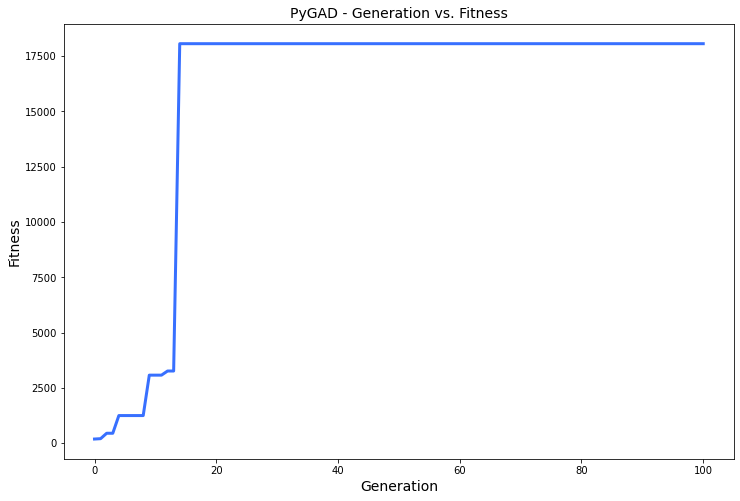

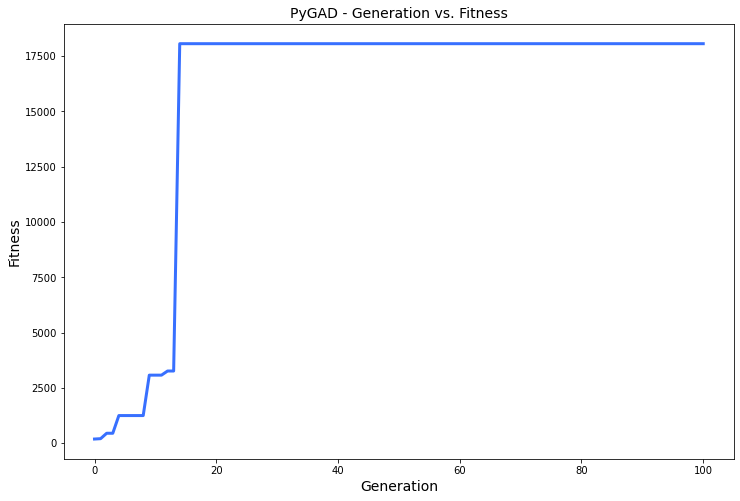

In [15]:
ga_instance.plot_result()

In [16]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.706 |===========| 26.508 |==================| 30.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 26.538 |==================| 423.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |==================| 25.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 26.472 |==================| 14.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |=========

In [17]:
# Check the model's prediction
prediction = numpy.sum(numpy.array(water_model.function_inputs)*solution)
print("Predicted output based on the best solution :{prediction}".format(prediction=prediction))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

Predicted output based on the best solution :0.500345620073479
Best fitness value reached after 14 generations.


In [18]:
# Check solution for confirmation
wn = wntr.network.WaterNetworkModel(water_model.inp_file_path)
results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0]))

pressure = results.node['pressure']
presssure_at_N6 = pressure.loc[:,water_model.node]
print(presssure_at_N6)

0    26.617834
Name: N6, dtype: float64


In [19]:
# Merge all our solutions per generation
solution_per_generation = glob.glob(f"{water_model.temp_dir}/GENERATION_*")
water_model.export_results(solutions = solution_per_generation, path=None, name='optimization-result-per-generation_'+water_model.node.lower())
result_generation = pd.read_csv(water_model.merged_results+'/optimization-result-per-generation_n6.csv')
result_generation

File Exported Successfully to path: ../leak_size_results/add_leak_node6/merged_results-new/results_for_/optimization-result-per-generation_n6.csv


,GENERATION,FITNESS
0,13.0,3260.593704
1,12.0,3260.593704
2,38.0,18062.578083
3,10.0,3073.937320
4,9.0,3073.937320
...,...,...
95,37.0,18062.578083
96,6.0,1246.267079
97,7.0,1246.267079
98,36.0,18062.578083


In [20]:
fitness_solution_per_population = glob.glob(f"{water_model.temp_dir}/FITNESS_SOLUTION_*")

water_model.export_results(solutions = fitness_solution_per_population, path=None, name='optimization-result-per-fitness_'+water_model.node.lower())
fitness_solution_per_population = pd.read_csv(water_model.merged_results+'/optimization-result-per-fitness_'+water_model.node.lower()+'.csv')
fitness_solution_per_population

File Exported Successfully to path: ../leak_size_results/add_leak_node6/merged_results-new/results_for_/optimization-result-per-fitness_n6.csv


,EMITTER_COEFFICIENT_SOLUTION,PRESSURE_OUTPUT,OUTPUT_DEMAND,FITNESS
0,0.263549,26.577305,10.1,27.064333
1,0.995847,26.461390,10.1,12.663335
2,0.952676,26.468345,10.1,13.886226
3,0.214165,26.584964,10.1,22.417865
4,0.471677,26.544807,10.1,224.664355
...,...,...,...,...
2825,0.015403,26.615581,10.1,13.293536
2826,0.420697,26.552801,10.1,80.357687
2827,0.402901,26.555586,10.1,65.661626
2828,0.366703,26.561243,10.1,47.876906


In [21]:
final_data = pd.merge(fitness_solution_per_population,result_generation, how='left',left_on='FITNESS',right_on='FITNESS')
final_data = final_data.sort_values(by='FITNESS',ascending=True)
final_data

,EMITTER_COEFFICIENT_SOLUTION,PRESSURE_OUTPUT,OUTPUT_DEMAND,FITNESS,GENERATION
1863,0.999566,26.460791,10.1,12.567893,NaN
2847,0.999185,26.460852,10.1,12.577614,NaN
1474,0.999028,26.460877,10.1,12.581613,NaN
2714,0.998834,26.460909,10.1,12.586551,NaN
2330,0.998276,26.460999,10.1,12.600838,NaN
...,...,...,...,...,...
2816,0.500346,26.540303,10.1,18062.578083,23.0
2815,0.500346,26.540303,10.1,18062.578083,35.0
2814,0.500346,26.540303,10.1,18062.578083,21.0
2812,0.500346,26.540303,10.1,18062.578083,34.0


In [22]:
# Get a summary statistics after optimization
final_data.describe()

,EMITTER_COEFFICIENT_SOLUTION,PRESSURE_OUTPUT,OUTPUT_DEMAND,FITNESS,GENERATION
count,2924.000000,2924.000000,2.924000e+03,2924.000000,100.000000
mean,0.495732,26.540805,1.010000e+01,627.675448,50.500000
std,0.283617,0.044588,5.063483e-13,3083.381469,29.011492
min,0.000222,26.460791,1.010000e+01,12.567893,1.000000
25%,0.253765,26.502418,1.010000e+01,17.191003,25.750000
50%,0.500346,26.540303,1.010000e+01,26.262039,50.500000
75%,0.740401,26.578875,1.010000e+01,53.560382,75.250000
max,1.014200,26.617906,1.010000e+01,18062.578083,100.000000


## Plot Results

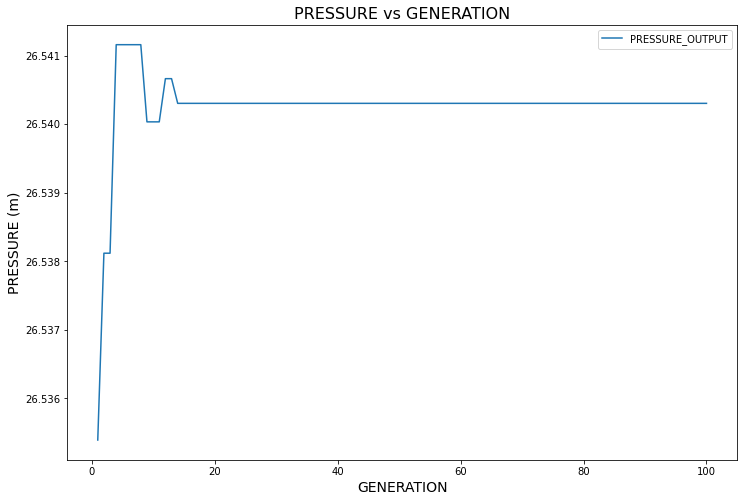

In [23]:
final_data.groupby(['GENERATION'])['PRESSURE_OUTPUT'].max().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('PRESSURE (m)',fontsize=14)
plt.title('PRESSURE vs GENERATION',fontsize=16)
plt.savefig(water_model.plots_dir+"/PRESSURE_VS_GENERATION.png")
plt.show();
plt.close()

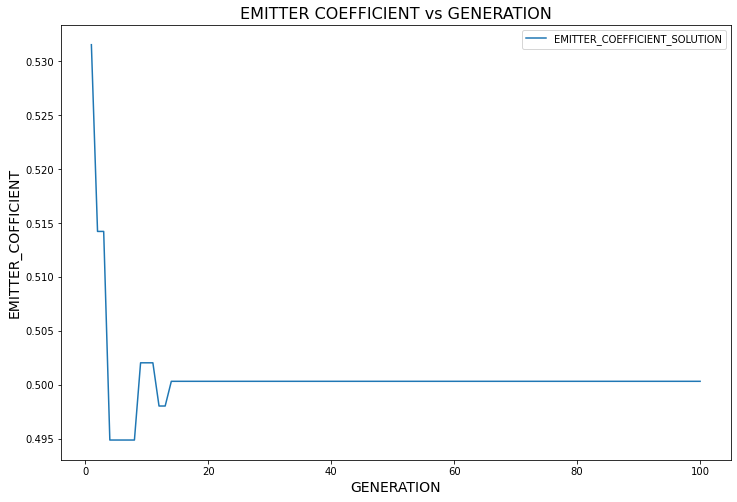

<Figure size 864x576 with 0 Axes>

In [27]:
final_data.groupby(['GENERATION'])['EMITTER_COEFFICIENT_SOLUTION'].min().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('EMITTER_COFFICIENT',fontsize=14)
plt.title('EMITTER COEFFICIENT vs GENERATION',fontsize=16)
plt.show();
plt.savefig(f"{water_model.plots_dir}/EMITTER_COEFFICIENT.png");

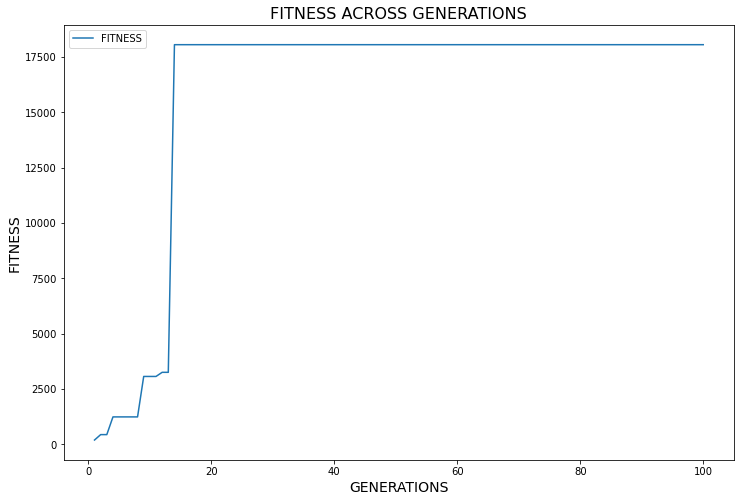

In [25]:
final_data.groupby(['GENERATION'])['FITNESS'].max().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('FITNESS',fontsize=14)
plt.title('FITNESS ACROSS GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model.plots_dir}/FITNESS_GEN.png")
plt.close()

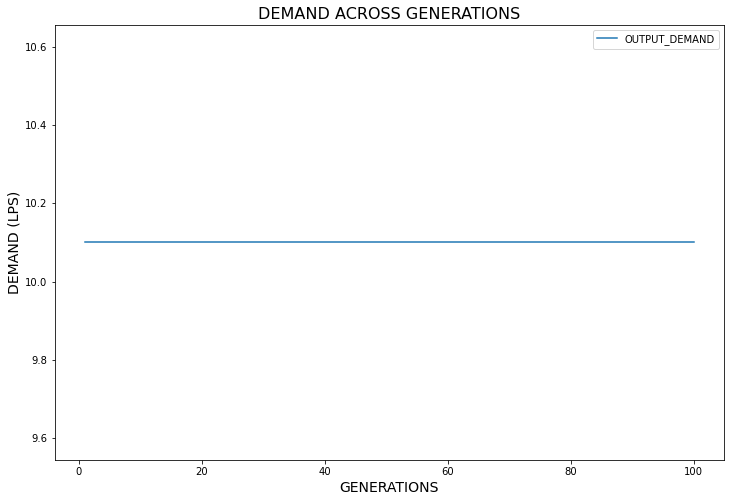

In [26]:
final_data.groupby(['GENERATION'])['OUTPUT_DEMAND'].max().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('DEMAND (LPS)',fontsize=14)
plt.title('DEMAND ACROSS GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model.plots_dir}/DEMAND_VS_GEN.png")
plt.close()

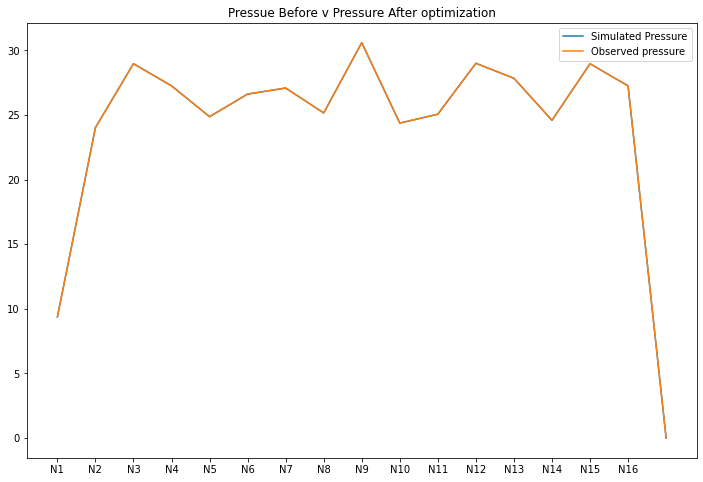

In [55]:
# Plot results on the network:
pressure_before_simulation = pressure_at_0hr.node['pressure'].iloc[:]

# Plot solution vs measurements
plt.plot(pressure_before_simulation.squeeze().values);
plt.plot(pressure.squeeze().values)
plt.legend(['Simulated Pressure','Observed pressure']);
plt.xticks(np.arange(16), ['N1','N2','N3','N4','N5','N6','N7','N8','N9','N10','N11','N12','N13','N14','N15','N16']);
plt.title('Pressue Before v Pressure After optimization');
plt.savefig(f"{water_model.plots_dir}/pressure_before_and_after_optimization.png")